# With TF

In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt

2023-07-20 12:14:43.209257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def show_image(image_list, label_list= None):
    """Plot images."""
    
    fig = plt.figure(figsize=(10, 5))
    for i, file in enumerate(image_list):
        
        # if image is numpy array
        if isinstance(file, np.ndarray):
            img= file
        # if image is PIL image
        else:
            img = np.array(file)
        
        print('Image shape:', img.shape)
        ax = fig.add_subplot(2, int(len(image_list)/2), i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
    
        if label_list is not None:
            ax.set_title(label_list[i])
    
    plt.tight_layout()
    plt.show()

## Load Dataset

In [3]:
train_path= 'dataset/dogs-vs-cat/train'
valid_path= 'dataset/dogs-vs-cat/valid'
test_path= 'dataset/dogs-vs-cat/test'
batch_size= 32

train_ds= image_dataset_from_directory(
    train_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'categorical',
)
val_ds= image_dataset_from_directory(
    valid_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'categorical',
)
test_ds= image_dataset_from_directory(
    test_path,
    image_size= (224, 224),
    batch_size= 32, 
    shuffle= True,
    seed= 1,
    label_mode= 'categorical',
)

Found 202 files belonging to 2 classes.
Found 103 files belonging to 2 classes.
Found 451 files belonging to 2 classes.


2023-07-20 12:14:45.900537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 12:14:45.903386: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Preprocess

In [4]:
# preprocessing
preprocessing= keras.Sequential([
    layers.Rescaling(scale= 1./255.),
    layers.Normalization(),

])
train_ds= train_ds.map(lambda x, y: (preprocessing(x), y))
val_ds= val_ds.map(lambda x, y: (preprocessing(x), y))
test_ds= test_ds.map(lambda x, y: (preprocessing(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


/home/anj/miniconda3/envs/deep-learning/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


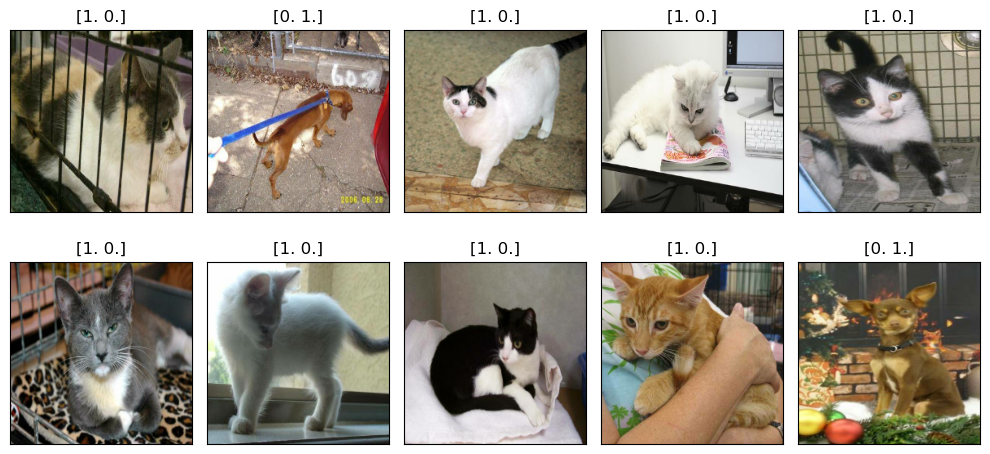

In [5]:
samples= train_ds.unbatch().take(10)
images= []
labels= []

for (image, label) in samples.as_numpy_iterator():
    images.append(image)
    labels.append(label)

show_image(images, labels)

## Create Model

In [6]:
base_model= vgg16.VGG16(include_top= False, 
                        weights= 'imagenet', 
                        input_shape= (224, 224, 3),
                        )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# freeze all layers
for layer in base_model.layers:
    layer.trainable= False

In [8]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
last_layer= base_model.get_layer(index= -1)
last_layer_output= last_layer.output
last_layer_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [10]:
x= Flatten()(last_layer_output)

x= Dense(64, activation= 'relu', name= 'FC_2')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(32, activation= 'relu', name= 'FC_3')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(16, activation= 'relu', name= 'FC_4')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)

x= Dense(2, activation= 'softmax', name= 'softmax')(x)

new_model= Model(inputs= base_model.input, outputs= x)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
new_model.compile(loss= 'binary_crossentropy', 
                  optimizer= Adam(learning_rate= 0.0001),
                  metrics= ['accuracy'])

In [12]:
epochs= 10
new_model.fit(train_ds, 
              validation_data= val_ds, 
              epochs= epochs, 
              verbose= 1)

Epoch 1/10


7/7 [==============================] - 36s 5s/step - loss: 0.8721 - accuracy: 0.5198 - val_loss: 0.7006 - val_accuracy: 0.4951
Epoch 2/10
7/7 [==============================] - 37s 6s/step - loss: 0.7563 - accuracy: 0.5545 - val_loss: 0.7013 - val_accuracy: 0.4854
Epoch 3/10
7/7 [==============================] - 38s 6s/step - loss: 0.7033 - accuracy: 0.6188 - val_loss: 0.6918 - val_accuracy: 0.5243
Epoch 4/10
7/7 [==============================] - 33s 5s/step - loss: 0.6569 - accuracy: 0.7178 - val_loss: 0.6896 - val_accuracy: 0.5534
Epoch 5/10
7/7 [==============================] - 37s 6s/step - loss: 0.6216 - accuracy: 0.7178 - val_loss: 0.6900 - val_accuracy: 0.5437
Epoch 6/10
7/7 [==============================] - 35s 5s/step - loss: 0.6394 - accuracy: 0.7376 - val_loss: 0.6901 - val_accuracy: 0.5437
Epoch 7/10
7/7 [==============================] - 33s 5s/step - loss: 0.5706 - accuracy: 0.7574 - val_loss: 0.6807 - val_accuracy: 0.5728
Epoch 8/10
7/7 [=============================

In [13]:
test_loss, test_acc= new_model.evaluate(test_ds)
print(f'Test accuracy = {test_acc: .4f} - test loss = {test_loss: 4f}')

15/15 [==============================] - 48s 3s/step - loss: 0.6140 - accuracy: 0.7095
Test accuracy =  0.7095 - test loss =  0.614040


# With Pytorch

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from pathlib import Path
import os
from PIL import Image
import numpy as np

In [26]:
batch_size= 8

transforms_train= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
])

transforms_test= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dir_= Path('dataset/dogs-vs-cat/train')
train_set= datasets.ImageFolder(dir_, transform= transforms_train)
train_dl= DataLoader(train_set, batch_size= batch_size, shuffle= True)

dir_= Path('dataset/dogs-vs-cat/valid')
val_set= datasets.ImageFolder(dir_, transform= transforms_train)
val_dl= DataLoader(val_set, batch_size= batch_size, shuffle= True)

dir_= Path('dataset/dogs-vs-cat/test')
test_set= datasets.ImageFolder(dir_, transform= transforms_test)
test_dl= DataLoader(test_set, batch_size= batch_size, shuffle= False)

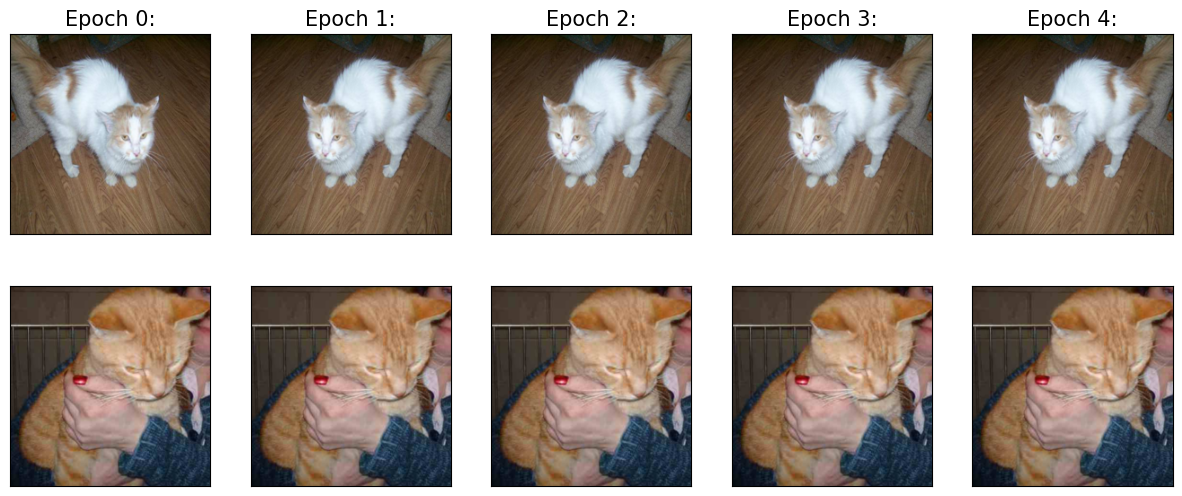

In [29]:
batch_size = 2
augment_samples= DataLoader(train_set, batch_size= batch_size)

fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(augment_samples))
    
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))